In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.7 MB/s eta 0:00:00


In [2]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from matplotlib.colors import ListedColormap
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
#strategy = tf.distribute.MirroredStrategy()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras

import segmentation_models as sm
import keras

Segmentation Models: using `tf.keras` framework.


In [4]:
print(keras.__version__)
print(tf.__version__)

2.13.1
2.13.0


In [5]:
Road = np.array([64, 42, 42])
Lane = np.array([255,0,0])
Undrivable = np.array([128,128,96])
Movable = np.array([0,255,102])
Car = np.array([204,0,255])

def set_labels(mask_dataset):
    labels = []
    for i in range(mask_dataset.shape[0]):
        label = rgb_to_2D_label(mask_dataset[i])
        labels.append(label)
    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=3)

    print("Unique labels in label dataset are: ", np.unique(labels))
    n_classes = len(np.unique(labels))
    from tensorflow.keras.utils import to_categorical
    labels_cat = to_categorical(labels, num_classes=n_classes)


    return labels_cat

def rgb_to_2D_label(label):

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Road, axis=-1)] = 0
    label_seg[np.all(label == Lane, axis=-1)] = 1
    label_seg[np.all(label == Undrivable, axis=-1)] = 2
    label_seg[np.all(label == Movable, axis=-1)] = 3
    label_seg[np.all(label == Car, axis=-1)] = 4

    label_seg = label_seg[:, :, 0]  # Just take the first channel, no need for all 3 channels

    return label_seg

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

IMAGES_PATH = "/kaggle/input/commaai2800/comma_dataset_max/images"
MASKS_PATH = '/kaggle/input/commaai2800/comma_dataset_max/masks'


image_files = os.listdir(IMAGES_PATH)
mask_files = os.listdir(MASKS_PATH)


numberOfClasses = 5

X = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((len(mask_files), IMG_HEIGHT, IMG_WIDTH, numberOfClasses), dtype=np.float32)


images = []
masks = []
for n, image_file in tqdm(enumerate(image_files), total=len(image_files), desc="Images..."):
    if os.path.splitext(image_file)[1].lower() == ".png":
      image_path = os.path.join(IMAGES_PATH, image_file)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (256,256))
      image = image / 255

      images.append(image)


for n, mask_file in tqdm(enumerate(mask_files), total=len(mask_files), desc="Train masks..."):
    if os.path.splitext(mask_file)[1].lower() == ".png":
      mask_path = os.path.join(MASKS_PATH, mask_file)
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      mask = cv2.resize(mask, (256,256))

      masks.append(mask)


X, y = np.array(images), np.array(masks)
del images
del masks
y = set_labels(y)

Train masks...: 100%|██████████| 2800/2800 [00:46<00:00, 60.25it/s]


Unique labels in label dataset are:  [0 1 2 3 4]


In [7]:
print("Image data shape is: ", X.shape)
print("Mask data shape is: ", y.shape)

Image data shape is:  (2800, 256, 256, 3)
Mask data shape is:  (2800, 256, 256, 5)


In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=2400,random_state=42) #add stratify=y to see difference later

In [9]:
n_classes=5
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [10]:
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [11]:
#Model 
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_processed = preprocess_input(X_train)
X_test_processed = preprocess_input(X_test)

In [12]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

#model.compile(optim, total_loss, metrics=metrics)

model.compile(optim, loss='categorical_crossentropy', metrics=metrics)
callbacks = [
    keras.callbacks.ModelCheckpoint('model_for_lane.h5', verbose=1, save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(),
]
#print(model.summary())

94592056/94592056 [==============================] - 2s 0us/step


In [13]:
history=model.fit(X_train_processed, 
          y_train,
          batch_size=8, 
          epochs=40,
          verbose=1,
          validation_split=0.15)


#model.save('/kaggle/working/res50_backbone_lane_detection.h5')

Epoch 1/40
255/255 [==============================] - 73s 142ms/step - loss: 0.4707 - iou_score: 0.4786 - f1-score: 0.5125 - val_loss: 1.3301 - val_iou_score: 0.1777 - val_f1-score: 0.2439
Epoch 2/40
255/255 [==============================] - 33s 129ms/step - loss: 0.1544 - iou_score: 0.6572 - f1-score: 0.7037 - val_loss: 1.3354 - val_iou_score: 0.2251 - val_f1-score: 0.3014
Epoch 3/40
255/255 [==============================] - 33s 130ms/step - loss: 0.1009 - iou_score: 0.7247 - f1-score: 0.7802 - val_loss: 0.2249 - val_iou_score: 0.5898 - val_f1-score: 0.6510
Epoch 4/40
255/255 [==============================] - 33s 129ms/step - loss: 0.0804 - iou_score: 0.7823 - f1-score: 0.8511 - val_loss: 0.1029 - val_iou_score: 0.7333 - val_f1-score: 0.8064
Epoch 5/40
255/255 [==============================] - 33s 130ms/step - loss: 0.0655 - iou_score: 0.8173 - f1-score: 0.8826 - val_loss: 0.0820 - val_iou_score: 0.8109 - val_f1-score: 0.8811
Epoch 6/40
255/255 [==============================] - 3

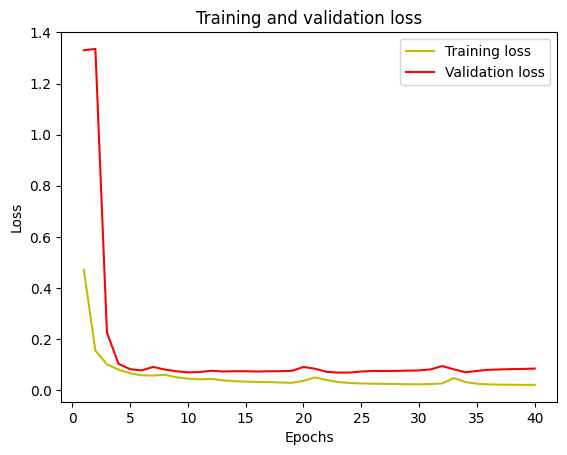

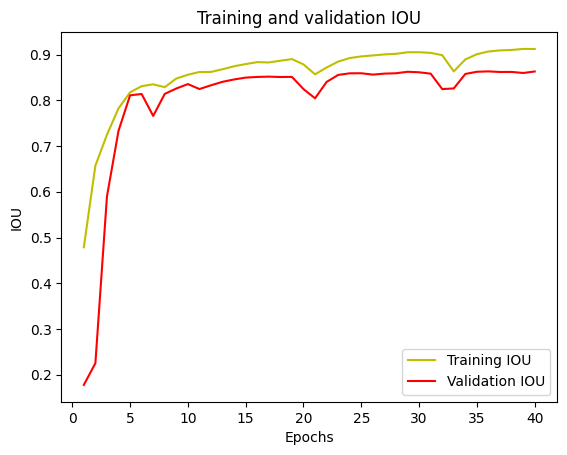

In [14]:
#training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [15]:
scores = model.evaluate(X_test_processed, y_test)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

13/13 [==============================] - 8s 273ms/step - loss: 0.0805 - iou_score: 0.8602 - f1-score: 0.9190
Loss: 0.08048
mean iou_score: 0.86019
mean f1-score: 0.91902


13/13 [==============================] - 2s 114ms/step


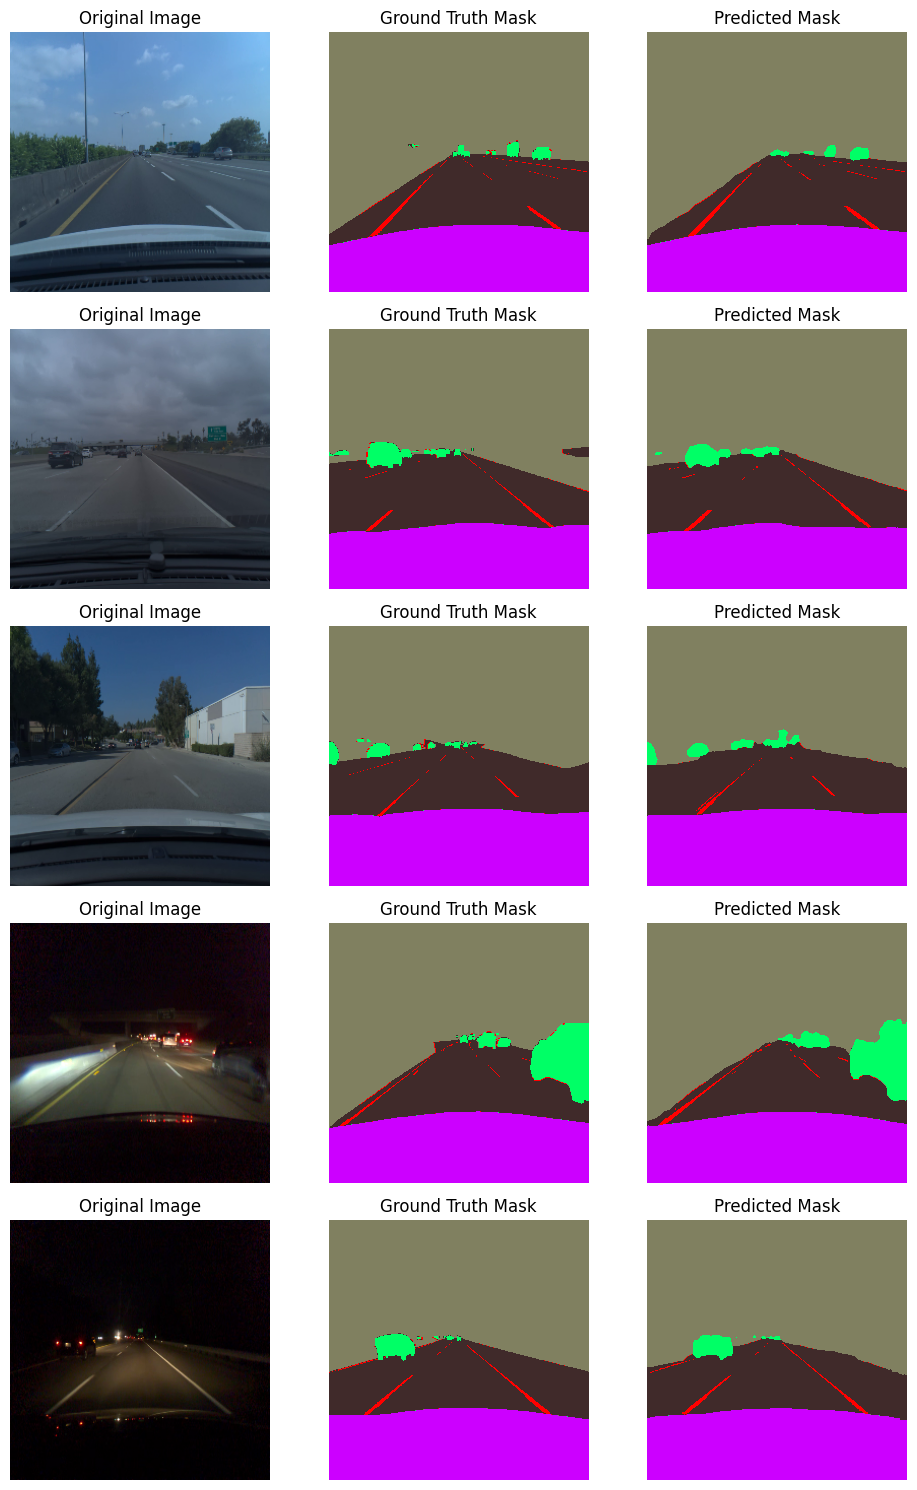

In [16]:
#model = load_model('/kaggle/working/res50_backbone_lane_detection.h5', compile=False)

y_pred = model.predict(X_test_processed)

num_samples = 5

colors = [ Road / 255.0,Lane / 255.0,Undrivable / 255.0,  Movable / 255.0, Car / 255.0]
cmap = ListedColormap(colors)

fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3*num_samples))

for i in range(num_samples):
    
    # original image
    axes[i, 0].imshow(X_test_processed[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    # ground truth mask
    ground_mask = np.argmax(y_test[i], axis=-1)
    axes[i, 1].imshow(ground_mask, cmap=cmap, vmin=0, vmax=4)
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis('off')

    # predicted mask
    predicted_mask = np.argmax(y_pred[i], axis=-1)
    axes[i, 2].imshow(predicted_mask, cmap=cmap, vmin=0, vmax=4)
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)